Author: Darshan Sundaram


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.model_selection import  KFold,RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.tree import DecisionTreeClassifier as dc
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, randint as sp_randint
from sklearn.svm import SVC, NuSVC, LinearSVC
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
%matplotlib inline
import math

I start off by installing all the required packages. I will be using pandas to wrangle the two data sets. Several built in functions in sklearn will assist me in developing and optimizing the following models. I will cycle through most of the applicable kernels and their parameters to find the optimized parameter set.

# Groundwork

After analyzing the features in the dataset, I start off my OneHotEncoding the multi-class (3 or more) features Pclass, Embarked, Title. I do this using the get_dummies function which essentially splits each multi class (3 or above) features in a column for each class within that feature. This will improve the robustness of my model. I do not modify the other features or perform feature selection as I want to see how they perform together first. Additonally, I will perform feature scaling before I train my model. 

## 1

In [12]:
q3_dataset1 = pd.read_csv('titanic_train.csv')
q3_dataset1 = pd.get_dummies(q3_dataset1, columns = ["Pclass", "Embarked", "Title"])
q3_dataset2 = pd.read_csv('titanic_val.csv')
q3_dataset2 = pd.get_dummies(q3_dataset2, columns = ["Pclass", "Embarked", "Title"])
q3_dataset2["Title_5"] = 0 #fixing missing column as val set doesn't have 5 as a title
q3_dataset3 = pd.read_csv('titanic_test.csv')
q3_dataset3 = pd.get_dummies(q3_dataset3, columns = ["Pclass", "Embarked", "Title"])
train_val = q3_dataset1.iloc[:,q3_dataset1.columns != "Survived"]
train_lab = q3_dataset1.iloc[:,0]

val_val = q3_dataset2.iloc[:,q3_dataset2.columns != "Survived"]
val_lab = q3_dataset2.iloc[:,0]

test_val = q3_dataset3



comb = pd.concat([q3_dataset1,q3_dataset2])
comb_val = comb.iloc[:,comb.columns != "Survived"]
comb_lab = comb.iloc[:,0]


### Exploration

In [13]:
print("The number of data points in the Training set is,", q3_dataset1.shape[0])
print("The number of data points in the Validation set is,", q3_dataset2.shape[0])
print("The number of data points in the Testing set is,", q3_dataset3.shape[0])

print("There are currently", train_val.shape[1], "features for each datapoint after OneHotEncoding my dataset, however we intially has 10 features")

The number of data points in the Training set is, 498
The number of data points in the Validation set is, 125
The number of data points in the Testing set is, 268
There are currently 18 features for each datapoint after OneHotEncoding my dataset, however we intially has 10 features


In [14]:
print("The average fare paid from the training sample is, ",round(q3_dataset1['Fare'].mean(),3))
print("The average age from the training sample is, ", round(q3_dataset1['Age'].mean(),3))

The average fare paid from the training sample is,  30.335
The average age from the training sample is,  28.984


## Model Selection | Decision Tree

In [15]:
Decisiontree = dc(max_depth = 1) #I define the function as dc when I imported it and randomly set the max depth as 1

In [16]:
accuracy = []

for i in range(1,10):
    model1 = [("Standard",StandardScaler()),('Decision Tree',dc(max_depth = i))]
    model = Pipeline(model1)
    model.fit(train_val,train_lab)
    accuracy.append(model.score(val_val,val_lab))

Text(0.5,1,'Accuracy vs Max_depth')

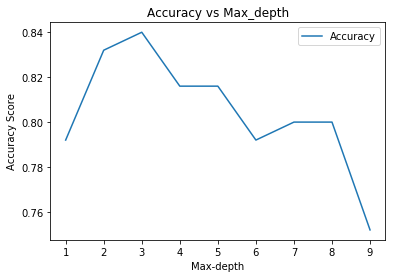

In [17]:
plt.figure()
plt.plot(range(1,10,1),accuracy, label = "Accuracy")

plt.legend(loc = 'best')
plt.xlabel("Max-depth")
plt.ylabel("Accuracy Score")
plt.title("Accuracy vs Max_depth")

In [18]:
accuracy.index(max(accuracy))

2

The optimal maximum depth of the tree is found to indexed at 2 or a max depth of 3. 

I found the maximum depth to be 3, however that was a raw accuracy over the validation set without cross validation. I only varies max_depth because that enabled me to plot the results. In this step, I will optimize the depth and other parameters using RandomizedSearch. I will get a different answer for maximum depth as I will perform CV on the entire training + validation set. Since it is a new dataset, we most likely will get a new value of max_depth. The results of this optimization will be used to predict on unseen data. 

In [19]:
param_grid = {
    'DC__max_depth': sp_randint(2,70),
    'DC__min_samples_leaf': sp_randint(1,20),
    'DC__min_samples_split': sp_randint(2,20),
    "DC__criterion": ["gini","entropy"]} #param grid

In [20]:
model1 = [("Standard",StandardScaler()),('DC',dc(random_state = 40))]
model = Pipeline(model1)
trial = RandomizedSearchCV(model,param_distributions = param_grid, n_iter = 400, scoring = "accuracy", cv = 10,verbose = 3, n_jobs = -1,random_state = 40)
trial.fit(comb_val,comb_lab)

Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 153 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 1113 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 2457 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:   21.5s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('Standard', StandardScaler(copy=True, with_mean=True, with_std=True)), ('DC', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=40,
            splitter='best'))]),
          fit_params=None, iid='warn', n_iter=400, n_jobs=-1,
          param_distributions={'DC__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F7531475F8>, 'DC__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F753154048>, 'DC__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F75369FCC0>, 'DC__criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jo

In [21]:
trial.best_score_  #10 fold CV accuracy score

0.8298555377207063

In [22]:
trial.best_params_

{'DC__criterion': 'entropy',
 'DC__max_depth': 9,
 'DC__min_samples_leaf': 10,
 'DC__min_samples_split': 2}

I will predict now on unseen data. 

In [23]:
pred = trial.predict(test_val)
test_out = pd.DataFrame(pred)
xport = test_out.to_csv('F003KDK_dt_prediction..csv', header = False, index = False) #Exporting to .csv


# Model 2

In [24]:
clf = [("Standard",StandardScaler()),("RF",RandomForestClassifier(random_state = 40))] #Feature Scaling and SVM classifier
rf = Pipeline(clf)

In [25]:
param_grid = {
    'RF__max_depth': sp_randint(2,70),
    'RF__n_estimators': sp_randint(15,200),
    'RF__min_samples_leaf': sp_randint(1,20),
    'RF__min_samples_split': sp_randint(2,20),
    "RF__criterion": ["gini","entropy"]} #param grid

In [26]:
trial3 = RandomizedSearchCV(rf,param_distributions = param_grid, n_iter = 400, scoring = "accuracy", cv = 10,verbose = 3, n_jobs = -1,random_state = 40)

In [27]:
trial3.fit(comb_val,comb_lab) #Train model

Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 2232 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 3064 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  1.4min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('Standard', StandardScaler(copy=True, with_mean=True, with_std=True)), ('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
    ...rs='warn', n_jobs=None,
            oob_score=False, random_state=40, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=400, n_jobs=-1,
          param_distributions={'RF__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F754BE6B00>, 'RF__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F754BE6978>, 'RF__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F754BE64A8>, 'RF__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F754BE66A0>, 'RF__

In [28]:
trial3.best_params_ #best params

{'RF__criterion': 'gini',
 'RF__max_depth': 39,
 'RF__min_samples_leaf': 2,
 'RF__min_samples_split': 8,
 'RF__n_estimators': 50}

In [29]:
trial3.best_score_ #best score

0.8507223113964687

The optimum parameters I found were a max depth of 7 and number of trees to be 148, resulting in a 10 fold accuracy of 84.9%. Of course, this optimal parameter is just one of the possibilities. There could be various other combinations that result in slighly higher accuracies or lower ones. 

The RandomizedsearchCV automatically choose the best parameters at the end of its search.

In [30]:
pred = trial3.predict(test_val)

In [31]:
test_out = pd.DataFrame(pred)
xport = test_out.to_csv('F003KDK_rf_prediction..csv', header = False, index = False) #Exporting to .csv


# Model 3 (SVM)

I will perform a GridSearchCV on all 3 kernels, and print out the 10 fold CV accuracy. The highest one will considered the best. 

### Linear SVM

In [32]:
LSVC = [("Robust",StandardScaler()),('SVM',LinearSVC(random_state = 40))]
piped1 = Pipeline(LSVC)
param_grid3 = [{ "SVM__C":np.logspace(-7, 8, 100,base = 2), "SVM__loss":["hinge","squared_hinge"]}]
grid3 = GridSearchCV(piped1,param_grid = param_grid3,cv = 10,scoring = "accuracy",verbose = 1) #GridSearch and parameter grid
grid3.fit(comb_val,comb_lab) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   47.8s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('Robust', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SVM', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=40, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'SVM__C': array([7.81250e-03, 8.67762e-03, ..., 2.30478e+02, 2.56000e+02]), 'SVM__loss': ['hinge', 'squared_hinge']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [33]:
grid3.best_params_

{'SVM__C': 0.013208182388799642, 'SVM__loss': 'squared_hinge'}

In [34]:
grid3.best_score_ 

0.8378812199036918

In [35]:
print("The 10 Fold CV accuracy of the Linear SVM is, ", round(grid3.best_score_ ,2)*100, "%")

The 10 Fold CV accuracy of the Linear SVM is,  84.0 %


### Polynomial SVM

In [36]:
clfpoly = [("Robust",RobustScaler()),('SVM',SVC(kernel = 'poly',random_state = 40))]  #Feature Scaling and SVM classifier
pipedpoly = Pipeline(clfpoly) 
param_gridpoly = [{ "SVM__gamma":np.logspace(-6, 3, 10,base = 2),"SVM__C":np.logspace(-7, 5, 10,base = 2), "SVM__degree":[2]}]
gridpoly = GridSearchCV(pipedpoly,param_grid = param_gridpoly,cv = 10,scoring = "accuracy",verbose = 3, n_jobs = -1) #GridSearch and parameter grid
gridpoly.fit(comb_val,comb_lab)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 11.3min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('Robust', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('SVM', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=40,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'SVM__gamma': array([0.01562, 0.03125, 0.0625 , 0.125  , 0.25   , 0.5    , 1.     ,
       2.     , 4.     , 8.     ]), 'SVM__C': array([7.81250e-03, 1.96863e-02, 4.96063e-02, 1.25000e-01, 3.14980e-01,
       7.93701e-01, 2.00000e+00, 5.03968e+00, 1.26992e+01, 3.20000e+01]), 'SVM__degree': [2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [37]:
gridpoly.best_score_

0.8426966292134831

In [38]:
gridpoly.best_params_

{'SVM__C': 0.0078125, 'SVM__degree': 2, 'SVM__gamma': 1.0}

In [39]:
print("The 10 fold CV accuracy of the Polynomial SVM is, ", round(gridpoly.best_score_,2)*100, "%")


The 10 fold CV accuracy of the Polynomial SVM is,  84.0 %


### Radial Basis SVM

In [40]:
clf2 = [("Min", RobustScaler()),('SVM',NuSVC(random_state=40))] #Feature scaling and SVM classifier
piped3 = Pipeline(clf2) #Pipeline classifier
param_grid2 = [{ "SVM__gamma":np.logspace(-4, 3, 10,base = 2),"SVM__nu":np.linspace(0.01,.50,20), "SVM__kernel":['rbf',]}] #sequence of 50 numbers from 0 to 50
grid2 = GridSearchCV(piped3,param_grid = param_grid2,cv = 10,scoring = "accuracy",verbose = 1) #GridSearch and parameter grid
grid2.fit(comb_val,comb_lab)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   47.5s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('Min', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('SVM', NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='rbf', max_iter=-1, nu=0.5, probability=False, random_state=40,
   shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'SVM__gamma': array([0.0625 , 0.10716, 0.18372, 0.31498, 0.54003, 0.92587, 1.5874 ,
       2.72158, 4.66612, 8.     ]), 'SVM__nu': array([0.01   , 0.03579, 0.06158, 0.08737, 0.11316, 0.13895, 0.16474,
       0.19053, 0.21632, 0.24211, 0.26789, 0.29368, 0.31947, 0.34526,
       0.37105, 0.39684, 0.42263, 0.44842, 0.47421, 0.5    ]), 'SVM__kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose

In [41]:
grid2.best_score_

0.8282504012841091

In [42]:
grid2.best_params_

{'SVM__gamma': 0.0625, 'SVM__kernel': 'rbf', 'SVM__nu': 0.3968421052631579}

The best 10 Fold CV accuracy is from the polynomial kernel with an accuracy of 84.27%. The RBF kernel gives us an accuracy of 82.8% and the linear kernel of 83.79%

In [43]:
#Predict

pred = gridpoly.predict(test_val)
test_out = pd.DataFrame(pred)
xport = test_out.to_csv('F003KDK_svm_prediction..csv', header = False, index = False) #Exporting to .csv
